In [302]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as colors
import numpy as np
# import pandas as pd    add later

In [341]:
class Agent:
    statuses = ["healthy", "sick", "recovered", "dead"]
    
    def __init__(self, index = None, status=statuses[0]):
        self.index = index
        self.status = status
        self.infection_time = 0
        
    def __str__(self):
        return self.status
    
    def __repr__(self):
        return self.__str__()
    
    def interact(self, other_status):
        if self.status == "healthy" and other_status == "sick":
            p = np.random.random()
            if p < 0.8:
                self.status = "sick"
    
    def step(self):
        if self.status == "sick":
            self.infection_time += 1
            if self.infection_time > 3:
                self.status = "recovered"
            p = np.random.random()
            if p < 0.15:
                self.status = "dead"        

In [285]:
def random_pairs(pop): #returns pairs of indices of the list "pop"
    size = len(pop)
    halfway = int(np.floor(size/2))
    indices = np.array([i for i in range(size)])
    
    np.random.shuffle(indices)
    partition_1 = indices[0 : halfway]
    partition_2 = indices[halfway : size]
    
    lineup = np.stack([partition_1, partition_2])
    
    pairs = np.transpose(lineup)  
        
    return pairs

def infection_step(population, distancing_factor=1):
    pairs = random_pairs(population)
    
    for pair in pairs:
        n = np.random.random()
        if n < distancing_factor:    # social distancing factor, 0 = total isolation
            agentA = population[pair[0]]
            agentB = population[pair[1]]
            
            population[pair[0]].interact(agentB.status)
            population[pair[1]].interact(agentA.status)
            
            for i in range(2):
                population[pair[i]].step()
        
    return population

In [295]:
population_size = 200
step_count = 40

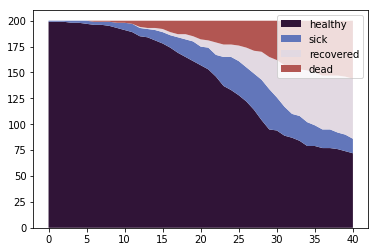

In [342]:
population = np.array([Agent() for _ in range(population_size)])
population[0].status = "sick"

healthy = [199]
sick = [1]
recovered = [0]
dead = [0]

for _ in range(step_count):
    infection_step(population, distancing_factor=0.4)
    stats = {"healthy": 0, "sick": 0, "recovered": 0, "dead": 0}
    for a in population:
        stats[a.status] += 1
    
    healthy.append(stats['healthy'])
    sick.append(stats['sick'])
    recovered.append(stats['recovered'])
    dead.append(stats['dead'])
    
x = [i for i in range(step_count + 1)]
cm = get_cmap("twilight_shifted")
colors = [cm(i/4.0) for i in range(4)]
    
fig, ax = plt.subplots()
ax.stackplot(x, healthy, sick, recovered, dead, labels=Agent.statuses, colors=colors)
ax.legend()
plt.show()